In [1]:
import math,numpy
import pandas
from scipy import linalg
import gaiaxpy
import pyvo

In [2]:
gaiaxpy.__version__

'1.1.4'

# Reconstruct XP covariance matrices

In [3]:
srv = pyvo.tap.TAPService("https://gaia.ari.uni-heidelberg.de/tap")
res = srv.run_sync(
    "select * from gaiadr3.xp_continuous_mean_spectrum"
    " where source_id=6223408420864").to_table()
Data = res[0]

In [4]:
# BP
CoeffsBP       = numpy.array(Data['bp_coefficients'], dtype=numpy.float)
ErrorsBP       = numpy.array(Data['bp_coefficient_errors'], dtype=numpy.float64)
CorrelationsBP = numpy.array(Data['bp_coefficient_correlations'], dtype=numpy.float64)
Ncoeffs        = len(ErrorsBP)
CovarBP        = numpy.zeros([Ncoeffs,Ncoeffs])
index          = 0
for j in range(Ncoeffs):
    CovarBP[j,j] = ErrorsBP[j]*ErrorsBP[j]
    for i in range(j):
        # upper triangular
        CovarBP[j,i] = CorrelationsBP[index]*ErrorsBP[j]*ErrorsBP[i]
        CovarBP[i,j] = CovarBP[j,i]
        index        = index + 1
# RP
CoeffsRP       = numpy.array(Data['rp_coefficients'], dtype=numpy.float)
ErrorsRP       = numpy.array(Data['rp_coefficient_errors'], dtype=numpy.float64)
CorrelationsRP = numpy.array(Data['rp_coefficient_correlations'], dtype=numpy.float64)
Ncoeffs        = len(ErrorsRP)
CovarRP        = numpy.zeros([Ncoeffs,Ncoeffs])
index          = 0
for j in range(Ncoeffs):
    CovarRP[j,j] = ErrorsRP[j]*ErrorsRP[j]
    for i in range(j):
        # upper triangular
        CovarRP[j,i] = CorrelationsRP[index]*ErrorsRP[j]*ErrorsRP[i]
        CovarRP[i,j] = CovarRP[j,i]
        index        = index + 1

# Choleksy decomposition: $C=L\cdot L^T$

In [5]:
LBP = linalg.cholesky(CovarBP)
LRP = linalg.cholesky(CovarRP)

# MC sampling

* normal random variate $u\sim {\rm Normal}(0,1)$
* Cholesky decomposition $C=L\cdot L^T$
* random variate $x = L\cdot u$
* covariance of $x$: 
\begin{equation}
\langle x\cdot x^T\rangle
=\langle L\cdot u\cdot u^T\cdot L^T\rangle
=L\cdot \underbrace{\langle u\cdot u^T\rangle}_{=I}\cdot L^T
=L\cdot L^T = C
\end{equation}

In [15]:
# Number of Monte-Carlo samples
N_SAMPLE = 100

numpy.random.seed(1)

bpLength, rpLength = len(CoeffsBP), len(CoeffsRP)

recs = []
for s in range(N_SAMPLE):
    newRec = dict(Data)
    newRec["bp_coefficients"] = CoeffsBP + numpy.dot(
        LBP, numpy.random.normal(0, 1, bpLength))    
    newRec["rp_coefficients"] = CoeffsRP + numpy.dot(
        LBP, numpy.random.normal(0, 1, rpLength))
    recs.append(newRec)

# Compute sampled spectra for each noise realisation

In [17]:
SPECTRAL_POINTS = numpy.array([400.+10*i for i in range(41)])
calib = gaiaxpy.calibrator.calibrator.calibrate(
    pandas.DataFrame.from_records(recs),
    sampling=SPECTRAL_POINTS,
    truncation=True,
    save_file=False)

In [25]:
spec = numpy.mean(calib[0]["flux"])

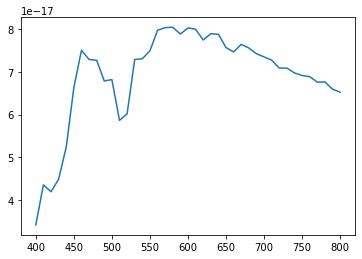

In [28]:
from matplotlib import pyplot
pyplot.plot(calib[1], spec)